# **Custom KNN for Iris Dataset**

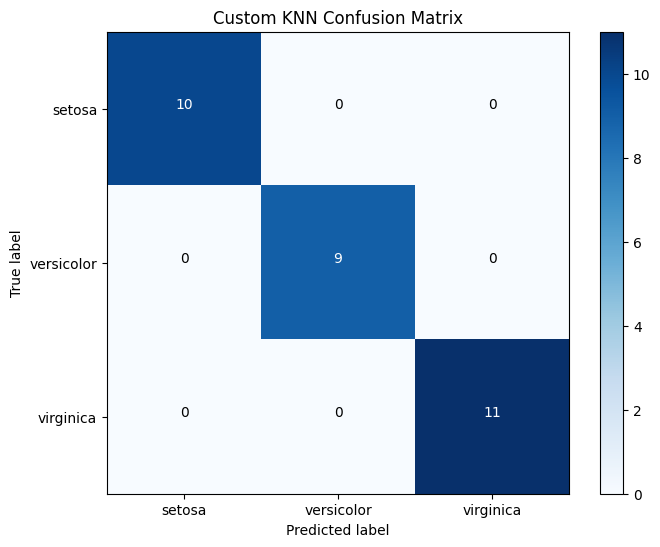

Custom KNN Metrics:
Accuracy: 1.0
F1-score: 1.0
Precision: 1.0
Recall: 1.0


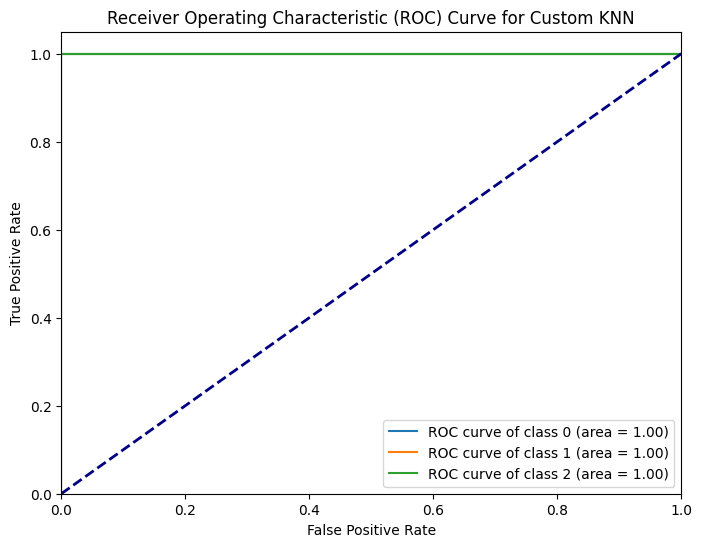

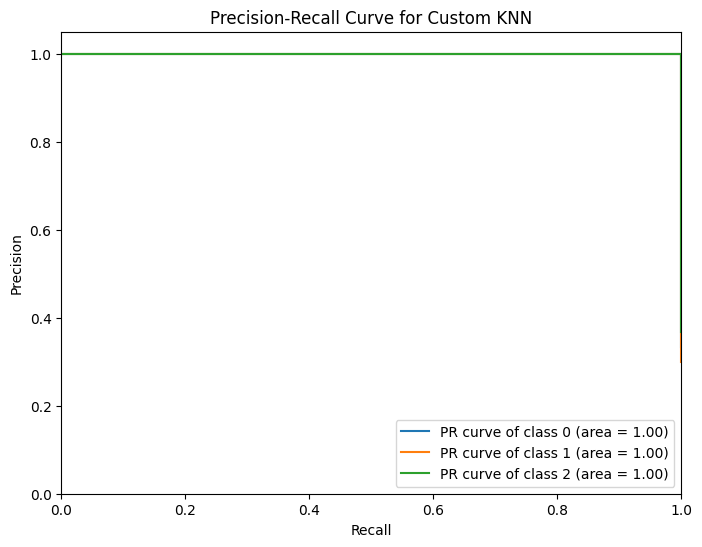

t-statistic: 0.0
p-value: 1.0
Fail to reject null hypothesis: The custom KNN model is not significantly different from the actual labels.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from collections import Counter
from scipy import stats

# Define custom distance function
def custom_distance(x1, x2):
    x1_numeric = np.asarray(x1, dtype=np.float64)
    x2_numeric = np.asarray(x2, dtype=np.float64)
    x1_clean = x1_numeric[~np.isnan(x1_numeric)]
    x2_clean = x2_numeric[~np.isnan(x2_numeric)]
    sum_of_squares = np.sum((x1_clean - x2_clean) ** 2)
    sum_of_quadratics = np.sum((x1_clean - x2_clean) ** 4)
    distance = 10 ** ((np.log(np.exp(1)) * (np.log(np.abs(sum_of_quadratics)) - np.log(np.abs(sum_of_squares)))) / (2 * np.log(10)))
    return distance

# Define KNN with custom distance and decision function
class CustomKNN:
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        distances = [custom_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.n_neighbors]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return max(set(k_nearest_labels), key=k_nearest_labels.count)  # Return the most common label

    def decision_scores(self, X):
        decision_scores = []
        for x in X:
            distances = [custom_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            decision_score = [Counter(k_nearest_labels)[i] / self.n_neighbors for i in range(3)]  # Ratio of each class in neighbors
            decision_scores.append(decision_score)
        return decision_scores

# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Preprocessing
# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train KNN model with custom distance
knn_custom = CustomKNN(n_neighbors=7)
knn_custom.fit(X_train, y_train)

# Evaluate model
y_pred_custom = knn_custom.predict(X_test)
conf_matrix_custom = confusion_matrix(y_test, y_pred_custom)

# Plot Confusion Matrix for custom KNN
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_custom, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Custom KNN Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1, 2], iris.target_names)
plt.yticks([0, 1, 2], iris.target_names)
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(conf_matrix_custom[i, j]), horizontalalignment='center',
                 color='white' if conf_matrix_custom[i, j] > conf_matrix_custom.max() / 2 else 'black')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Calculate metrics for custom KNN
accuracy_custom = accuracy_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom, average='macro')
precision_custom = precision_score(y_test, y_pred_custom, average='macro')
recall_custom = recall_score(y_test, y_pred_custom, average='macro')

# Print metrics for custom KNN
print("Custom KNN Metrics:")
print("Accuracy:", accuracy_custom)
print("F1-score:", f1_custom)
print("Precision:", precision_custom)
print("Recall:", recall_custom)

# Binarize the target variable
y_test_binary = label_binarize(y_test, classes=[0, 1, 2])

# Calculate decision scores for custom KNN
decision_scores_custom = knn_custom.decision_scores(X_test)

# Calculate false positive rate and truepositive rate for ROC curve
fpr_custom = dict()
tpr_custom = dict()
roc_auc_custom = dict()
for i in range(3):
    fpr_custom[i], tpr_custom[i], _ = roc_curve(y_test_binary[:, i], [x[i] for x in decision_scores_custom])
    roc_auc_custom[i] = auc(fpr_custom[i], tpr_custom[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr_custom[i], tpr_custom[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_custom[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Custom KNN')
plt.legend(loc="lower right")
plt.show()

# Calculate precision and recall for Precision-Recall curve
precision_custom = dict()
recall_custom = dict()
pr_auc_custom = dict()
for i in range(3):
    precision_custom[i], recall_custom[i], _ = precision_recall_curve(label_binarize(y_test, classes=[0, 1, 2])[:, i], [x[i] for x in decision_scores_custom])
    pr_auc_custom[i] = auc(recall_custom[i], precision_custom[i])

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(recall_custom[i], precision_custom[i], label='PR curve of class {0} (area = {1:0.2f})'.format(i, pr_auc_custom[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Custom KNN')
plt.legend(loc="lower right")
plt.show()

from scipy import stats
# Perform t-test and p-test
t_stat, p_val = stats.ttest_ind(y_test, y_pred_custom)
print("t-statistic:", t_stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("Reject null hypothesis: The custom KNN model is significantly different from the actual labels.")
else:
    print("Fail to reject null hypothesis: The custom KNN model is not significantly different from the actual labels.")

# **Parameter Sensitivity for Iris Dataset**

<ipython-input-4-9075a59d6308>:94: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([result[0] for result in results_custom_knn], [result[3] for result in results_custom_knn], 'bo-', color='darkorange')
<ipython-input-4-9075a59d6308>:100: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([result[0] for result in results_custom_knn], error_custom_knn, 'bo-', color='darkorange')


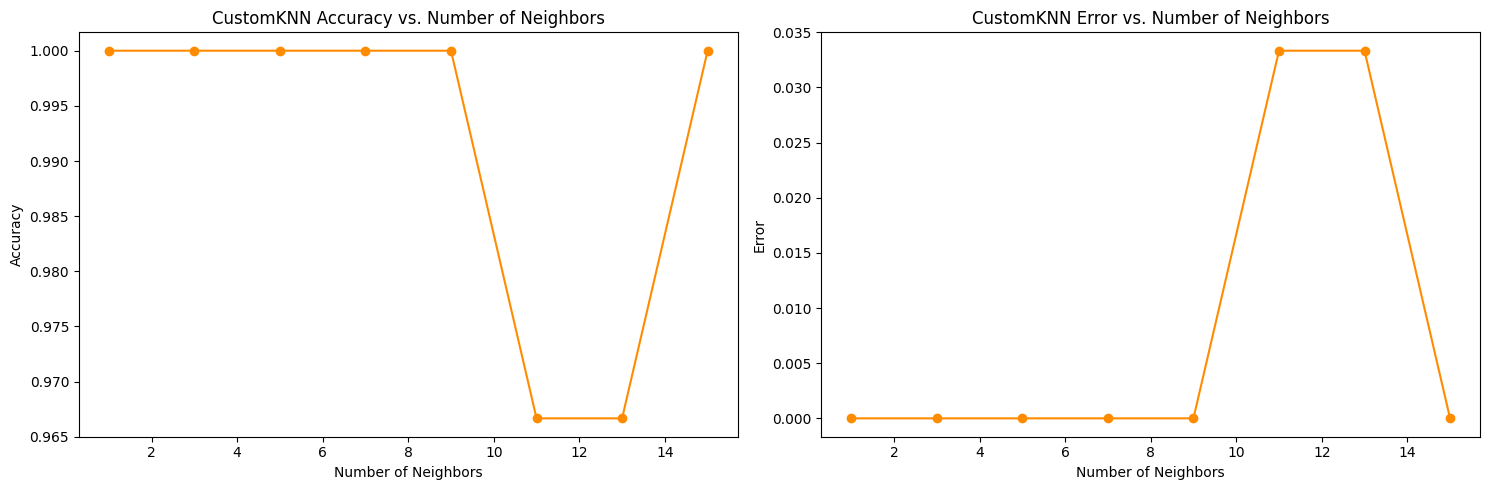

<ipython-input-4-9075a59d6308>:113: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([result[0] for result in metric_results], [result[3] for result in metric_results], 'bo-', color='darkorange')


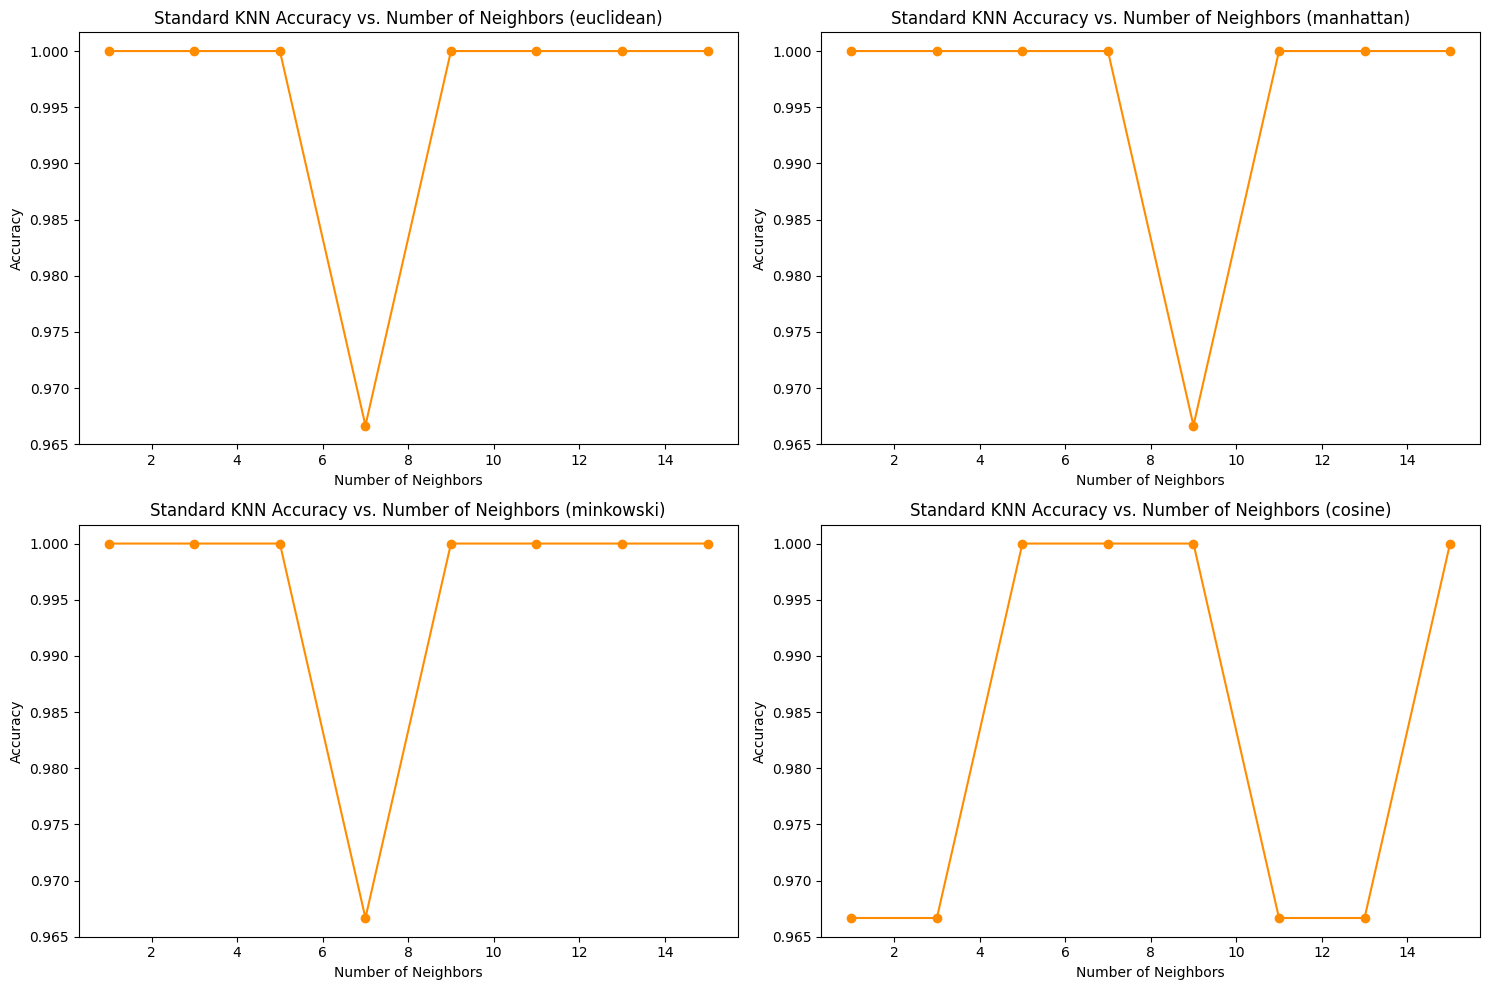

<ipython-input-4-9075a59d6308>:132: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([result[0] for result in results_knn if result[1] == metric], error_knn[metric], 'bo-', color='darkorange')


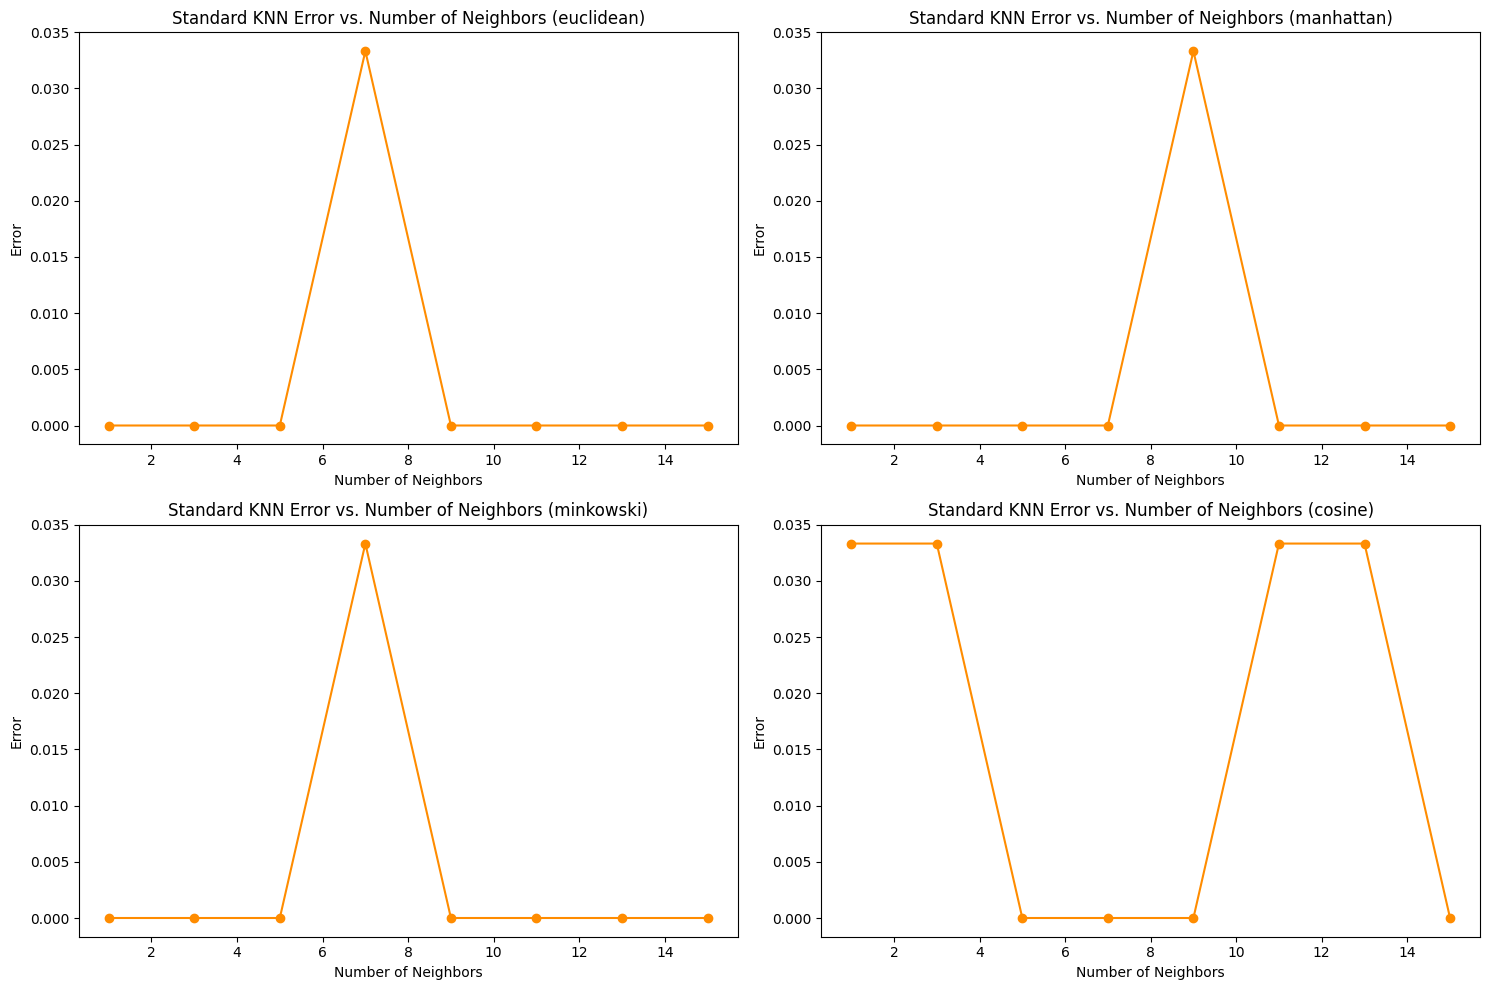

([(1, 'custom_distance', 0.0988306999206543, 1.0),
  (3, 'custom_distance', 0.11504340171813965, 1.0),
  (5, 'custom_distance', 0.12238788604736328, 1.0),
  (7, 'custom_distance', 0.10297799110412598, 1.0),
  (9, 'custom_distance', 0.10309457778930664, 1.0),
  (11, 'custom_distance', 0.10106778144836426, 0.9666666666666667),
  (13, 'custom_distance', 0.10615253448486328, 0.9666666666666667),
  (15, 'custom_distance', 0.105194091796875, 1.0)],
 [(1, 'euclidean', 0.004091501235961914, 1.0),
  (1, 'manhattan', 0.003225564956665039, 1.0),
  (1, 'minkowski', 0.003199338912963867, 1.0),
  (1, 'cosine', 0.004051685333251953, 0.9666666666666667),
  (3, 'euclidean', 0.003356456756591797, 1.0),
  (3, 'manhattan', 0.0036695003509521484, 1.0),
  (3, 'minkowski', 0.0034880638122558594, 1.0),
  (3, 'cosine', 0.004125356674194336, 0.9666666666666667),
  (5, 'euclidean', 0.003340482711791992, 1.0),
  (5, 'manhattan', 0.0034041404724121094, 1.0),
  (5, 'minkowski', 0.00341033935546875, 1.0),
  (5, 'cos

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt

# Load dataset
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CustomKNN class
class CustomKNN:
    def __init__(self, n_neighbors, metric):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            distances = []
            for j in range(len(self.X_train)):
                distance = self.metric(X[i], self.X_train[j])
                distances.append((distance, self.y_train[j]))
            distances.sort(key=lambda x: x[0])
            k_neighbors = [distances[i][1] for i in range(self.n_neighbors)]
            prediction = max(set(k_neighbors), key=k_neighbors.count)
            predictions.append(prediction)
        return predictions

# Define the custom distance metric
def custom_distance(x1, x2):
    x1_numeric = np.asarray(x1, dtype=np.float64)
    x2_numeric = np.asarray(x2, dtype=np.float64)
    x1_clean = x1_numeric[~np.isnan(x1_numeric)]
    x2_clean = x2_numeric[~np.isnan(x2_numeric)]
    sum_of_squares = np.sum((x1_clean - x2_clean) ** 2)
    sum_of_quadratics = np.sum((x1_clean - x2_clean) ** 4)
    if sum_of_quadratics == 0:
        return 0
    else:
        distance = 10 ** ((np.log(np.exp(1)) * (np.log(np.abs(sum_of_quadratics)) - np.log(np.abs(sum_of_squares)))) / (2 * np.log(10)))
        return distance

# Perform parameter sensitivity analysis for CustomKNN
n_neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15]
metric_range = [custom_distance]

results_custom_knn = []
for n_neighbors in n_neighbors_range:
    for metric in metric_range:
        custom_knn = CustomKNN(n_neighbors, metric)
        start_time = time.time()
        custom_knn.fit(X_train, y_train)
        y_pred = custom_knn.predict(X_test)
        end_time = time.time()
        execution_time = end_time - start_time
        accuracy = accuracy_score(y_test, y_pred)
        results_custom_knn.append((n_neighbors, metric.__name__, execution_time, accuracy))

# Perform parameter sensitivity analysis for standard KNN
metric_range = ['euclidean', 'manhattan', 'minkowski','cosine']

results_knn = []
for n_neighbors in n_neighbors_range:
    for metric in metric_range:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        start_time = time.time()
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        end_time = time.time()
        execution_time = end_time - start_time
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        results_knn.append((n_neighbors, metric, execution_time, accuracy))

# Calculate error for custom KNN
error_custom_knn = [1 - result[3] for result in results_custom_knn]

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot([result[0] for result in results_custom_knn], [result[3] for result in results_custom_knn], 'bo-', color='darkorange')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('CustomKNN Accuracy vs. Number of Neighbors')

plt.subplot(1, 2, 2)
plt.plot([result[0] for result in results_custom_knn], error_custom_knn, 'bo-', color='darkorange')
plt.xlabel('Number of Neighbors')
plt.ylabel('Error')
plt.title('CustomKNN Error vs. Number of Neighbors')

plt.tight_layout()
plt.show()

# Plot results for standard KNN
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metric_range):
    metric_results = [result for result in results_knn if result[1] == metric]
    plt.subplot(2, 2, i+1)
    plt.plot([result[0] for result in metric_results], [result[3] for result in metric_results], 'bo-', color='darkorange')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.title(f'Standard KNN Accuracy vs. Number of Neighbors ({metric})')

plt.tight_layout()
plt.show()

# Calculate error for standard KNN
error_knn = {}
for metric in metric_range:
    metric_results = [result for result in results_knn if result[1] == metric]
    error = [1 - result[3] for result in metric_results]
    error_knn[metric] = error

# Plot error for standard KNN
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metric_range):
    plt.subplot(2, 2, i+1)
    plt.plot([result[0] for result in results_knn if result[1] == metric], error_knn[metric], 'bo-', color='darkorange')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Error')
    plt.title(f'Standard KNN Error vs. Number of Neighbors ({metric})')

plt.tight_layout()
plt.show()


results_custom_knn, results_knn

# **Custom KNN for UCI Wine Dataset**

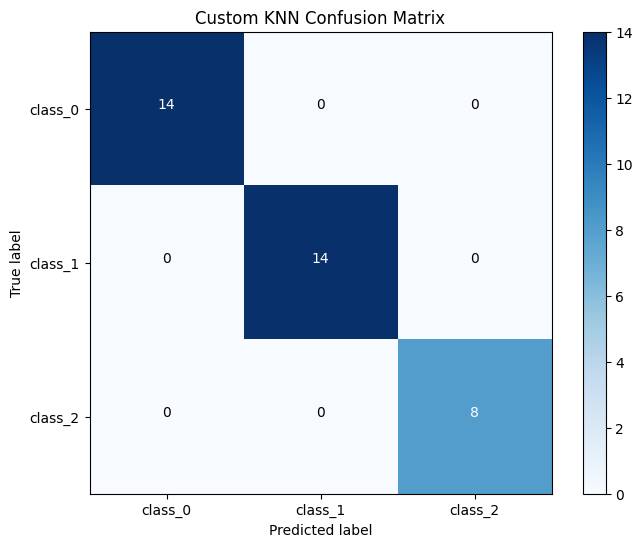

Custom KNN Metrics:
Accuracy: 1.0
F1-score: 1.0
Precision: 1.0
Recall: 1.0


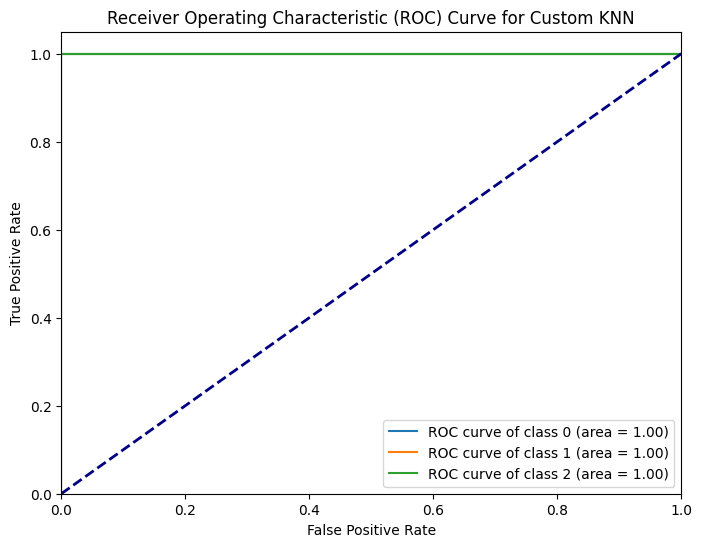

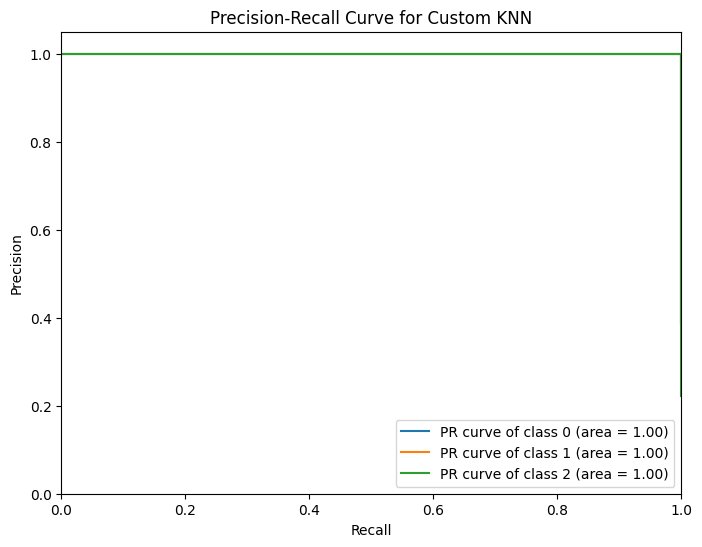

t-statistic: 0.0
p-value: 1.0
Fail to reject null hypothesis: The custom KNN model is not significantly different from the actual labels.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from collections import Counter

# Define custom distance function
def custom_distance(x1, x2):
    x1_numeric = np.asarray(x1, dtype=np.float64)
    x2_numeric = np.asarray(x2, dtype=np.float64)
    x1_clean = x1_numeric[~np.isnan(x1_numeric)]
    x2_clean = x2_numeric[~np.isnan(x2_numeric)]
    sum_of_squares = np.sum((x1_clean - x2_clean)**2)
    sum_of_quadratics = np.sum((x1_clean - x2_clean)**4)
    distance = 10**((np.log(np.exp(1)) * (np.log(np.abs(sum_of_quadratics)) - np.log(np.abs(sum_of_squares)))) / (2 * np.log(10)))
    return distance

# Define KNN with custom distance and decision function
class CustomKNN:
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        distances = [custom_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.n_neighbors]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return max(set(k_nearest_labels), key=k_nearest_labels.count)  # Return the most common label

    def decision_scores(self, X):
        scores = np.zeros((X.shape[0], len(set(self.y_train))))
        for idx, x in enumerate(X):
            distances = [custom_distance(x, x_train) for x_train in self.X_train]
            k_indices = np.argsort(distances)[:self.n_neighbors]
            k_nearest_labels = [self.y_train[i] for i in k_indices]
            label_counts = Counter(k_nearest_labels)
            for label in label_counts:
                scores[idx, label] = label_counts[label] / self.n_neighbors
        return scores

# Load Wine dataset
wine = load_wine()
X = wine.data
y = wine.target

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train KNN model with custom distance
knn_custom = CustomKNN(n_neighbors=11)
knn_custom.fit(X_train, y_train)

# Evaluate model
y_pred_custom = knn_custom.predict(X_test)
conf_matrix_custom = confusion_matrix(y_test, y_pred_custom)

# Plot Confusion Matrix for custom KNN
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_custom, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Custom KNN Confusion Matrix')
plt.colorbar()
plt.xticks(range(3), wine.target_names)
plt.yticks(range(3), wine.target_names)
for i in range(3):
    for j in range(3):
        plt.text(j, i, str(conf_matrix_custom[i, j]), horizontalalignment='center', color='white' if conf_matrix_custom[i, j] > conf_matrix_custom.max()/2 else 'black')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Calculate metrics for custom KNN
accuracy_custom = accuracy_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom, average='weighted')
precision_custom = precision_score(y_test, y_pred_custom, average='weighted')
recall_custom = recall_score(y_test, y_pred_custom, average='weighted')

# Print metrics for custom KNN
print("Custom KNN Metrics:")
print("Accuracy:", accuracy_custom)
print("F1-score:", f1_custom)
print("Precision:", precision_custom)
print("Recall:", recall_custom)

from sklearn.preprocessing import label_binarize

# Binarize the target variable
y_test_binary = label_binarize(y_test, classes=[0, 1, 2])

# Calculate decision scores for custom KNN
decision_scores_custom = knn_custom.decision_scores(X_test)

# Calculate false positive rate and true positive rate for ROC curve
fpr_custom = dict()
tpr_custom = dict()
roc_auc_custom = dict()
for i in range(3):
    fpr_custom[i], tpr_custom[i], _ = roc_curve(y_test_binary[:, i], decision_scores_custom[:, i])
    roc_auc_custom[i] = auc(fpr_custom[i], tpr_custom[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(fpr_custom[i], tpr_custom[i], label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc_custom[i]))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Custom KNN')
plt.legend(loc="lower right")
plt.show()

# Calculate precision and recall for Precision-Recall curve
precision_custom = dict()
recall_custom = dict()
pr_auc_custom = dict()
for i in range(3):
    precision_custom[i], recall_custom[i], _ = precision_recall_curve(y_test_binary[:, i], decision_scores_custom[:, i])
    pr_auc_custom[i] = auc(recall_custom[i], precision_custom[i])

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
for i in range(3):
    plt.plot(recall_custom[i], precision_custom[i], label='PR curve of class {0} (area = {1:0.2f})'.format(i, pr_auc_custom[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Custom KNN')
plt.legend(loc="lower right")
plt.show()

from scipy import stats
# Perform t-test and p-test
t_stat, p_val = stats.ttest_ind(y_test, y_pred_custom)
print("t-statistic:", t_stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("Reject null hypothesis: The custom KNN model is significantly different from the actual labels.")
else:
    print("Fail to reject null hypothesis: The custom KNN model is not significantly different from the actual labels.")


# **Parameter Sensitivity for UCI Wine Dataset**

<ipython-input-6-838176ebcdcc>:86: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, accuracies, 'bo-', color='darkorange')
<ipython-input-6-838176ebcdcc>:92: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(k_values, errors, 'bo-', color='darkorange')


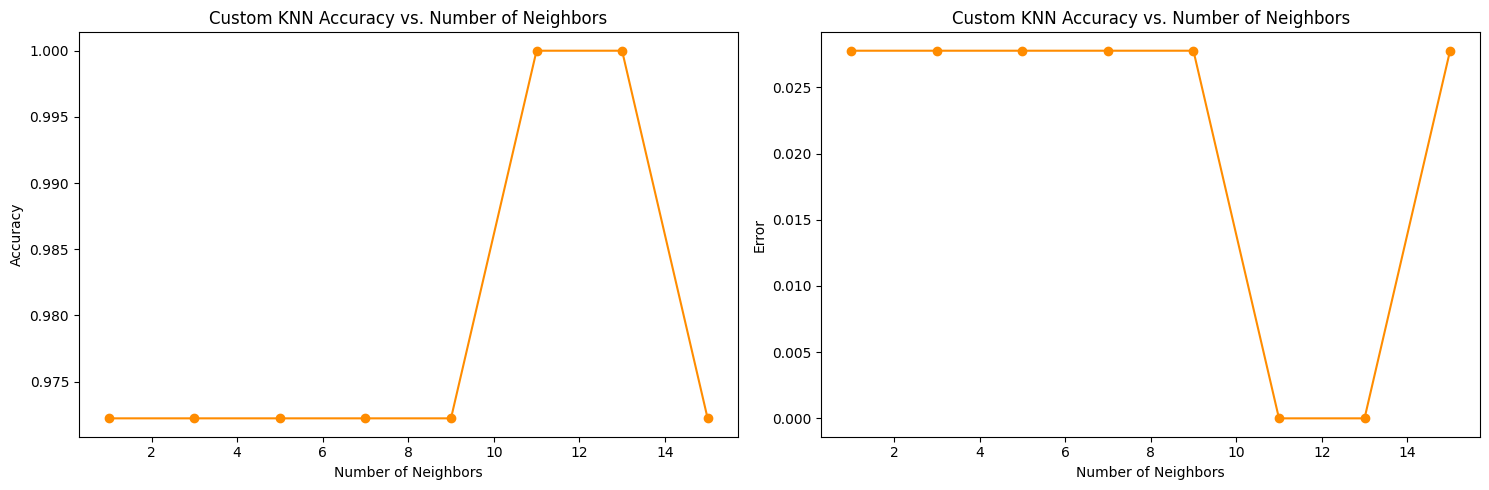

    k  accuracy
0   1  0.972222
1   3  0.972222
2   5  0.972222
3   7  0.972222
4   9  0.972222
5  11  1.000000
6  13  1.000000
7  15  0.972222
    k  precision
0   1   0.975309
1   3   0.975309
2   5   0.975309
3   7   0.975309
4   9   0.975309
5  11   1.000000
6  13   1.000000
7  15   0.975309
    k    recall
0   1  0.972222
1   3  0.972222
2   5  0.972222
3   7  0.972222
4   9  0.972222
5  11  1.000000
6  13  1.000000
7  15  0.972222
    k        f1
0   1  0.972525
1   3  0.972525
2   5  0.972525
3   7  0.972525
4   9  0.972525
5  11  1.000000
6  13  1.000000
7  15  0.972525


In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
from collections import Counter

# Define custom distance function
def custom_distance(x1, x2):
    x1_numeric = np.asarray(x1, dtype=np.float64)
    x2_numeric = np.asarray(x2, dtype=np.float64)
    x1_clean = x1_numeric[~np.isnan(x1_numeric)]
    x2_clean = x2_numeric[~np.isnan(x2_numeric)]
    sum_of_squares = np.sum((x1_clean - x2_clean)**2)
    sum_of_quadratics = np.sum((x1_clean - x2_clean)**4)
    distance = 10**((np.log(np.exp(1)) * (np.log(np.abs(sum_of_quadratics)) - np.log(np.abs(sum_of_squares)))) / (2 * np.log(10)))
    return distance

# Define KNN with custom distance and decision function
class CustomKNN:
    def __init__(self, n_neighbors):
        self.n_neighbors = n_neighbors

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        y_pred = [self._predict(x) for x in X]
        return np.array(y_pred)

    def _predict(self, x):
        distances = [custom_distance(x, x_train) for x_train in self.X_train]
        k_indices = np.argsort(distances)[:self.n_neighbors]
        k_nearest_labels = [self.y_train[i] for i in k_indices]
        return max(set(k_nearest_labels), key=k_nearest_labels.count)  # Return the most common label

# Load Wine dataset
wine = load_wine()
X = wine.data
y = wine.target

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Arrays to store accuracy and error rates
k_values = range(1, 16, 2)
accuracies = []
errors = []
precision_score_custom  = []
recall_score_custom = []
f1_score_custom = []

# Iterate over different values of k

for k in k_values:
    # Train KNN model with custom distance
    knn_custom = CustomKNN(n_neighbors=k)
    knn_custom.fit(X_train, y_train)

    # Evaluate model
    y_pred_custom = knn_custom.predict(X_test)
    accuracy_custom = accuracy_score(y_test, y_pred_custom)
    error_custom = 1 - accuracy_custom
    precision_custom = precision_score(y_test, y_pred_custom, average='weighted')
    recall_custom = recall_score(y_test, y_pred_custom, average='weighted')
    f1_custom = f1_score(y_test, y_pred_custom, average='weighted')

    # Store metrics
    accuracies.append(accuracy_custom)
    errors.append(error_custom)
    precision_score_custom.append(precision_custom)
    recall_score_custom.append(recall_custom)
    f1_score_custom.append(f1_custom)

# Plotting accuracy and error rate
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(k_values, accuracies, 'bo-', color='darkorange')
plt.title('Custom KNN Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(k_values, errors, 'bo-', color='darkorange')
plt.title('Custom KNN Accuracy vs. Number of Neighbors')
plt.xlabel('Number of Neighbors')
plt.ylabel('Error')

plt.tight_layout()
plt.show()

accuracies_df = pd.DataFrame({'k': k_values, 'accuracy': accuracies})
precision_df = pd.DataFrame({'k': k_values, 'precision': precision_score_custom})
recall_df = pd.DataFrame({'k': k_values, 'recall': recall_score_custom})
f1_df = pd.DataFrame({'k': k_values, 'f1': f1_score_custom})

print(accuracies_df)
print(precision_df)
print(recall_df)
print(f1_df)


# **Parameter Sensitivity for Standard KNN**

<ipython-input-7-0c6352f385c1>:55: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(metric_results['k'], error, 'bo-', color='darkorange')


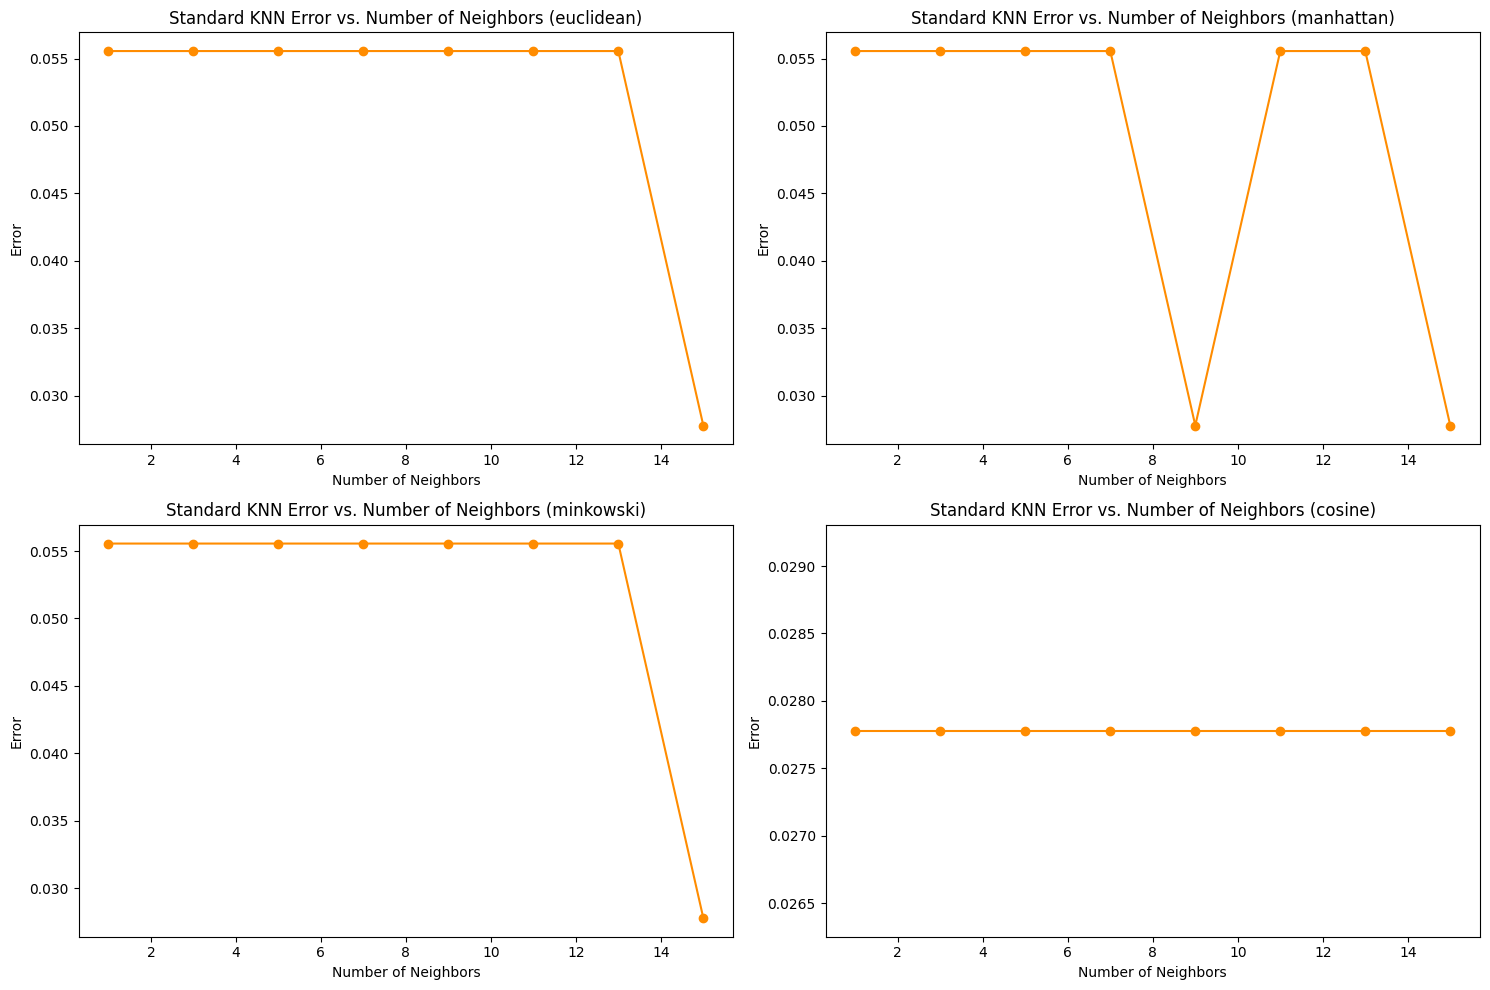

<ipython-input-7-0c6352f385c1>:69: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(metric_results['k'], metric_results['accuracy'], 'bo-', color='darkorange')


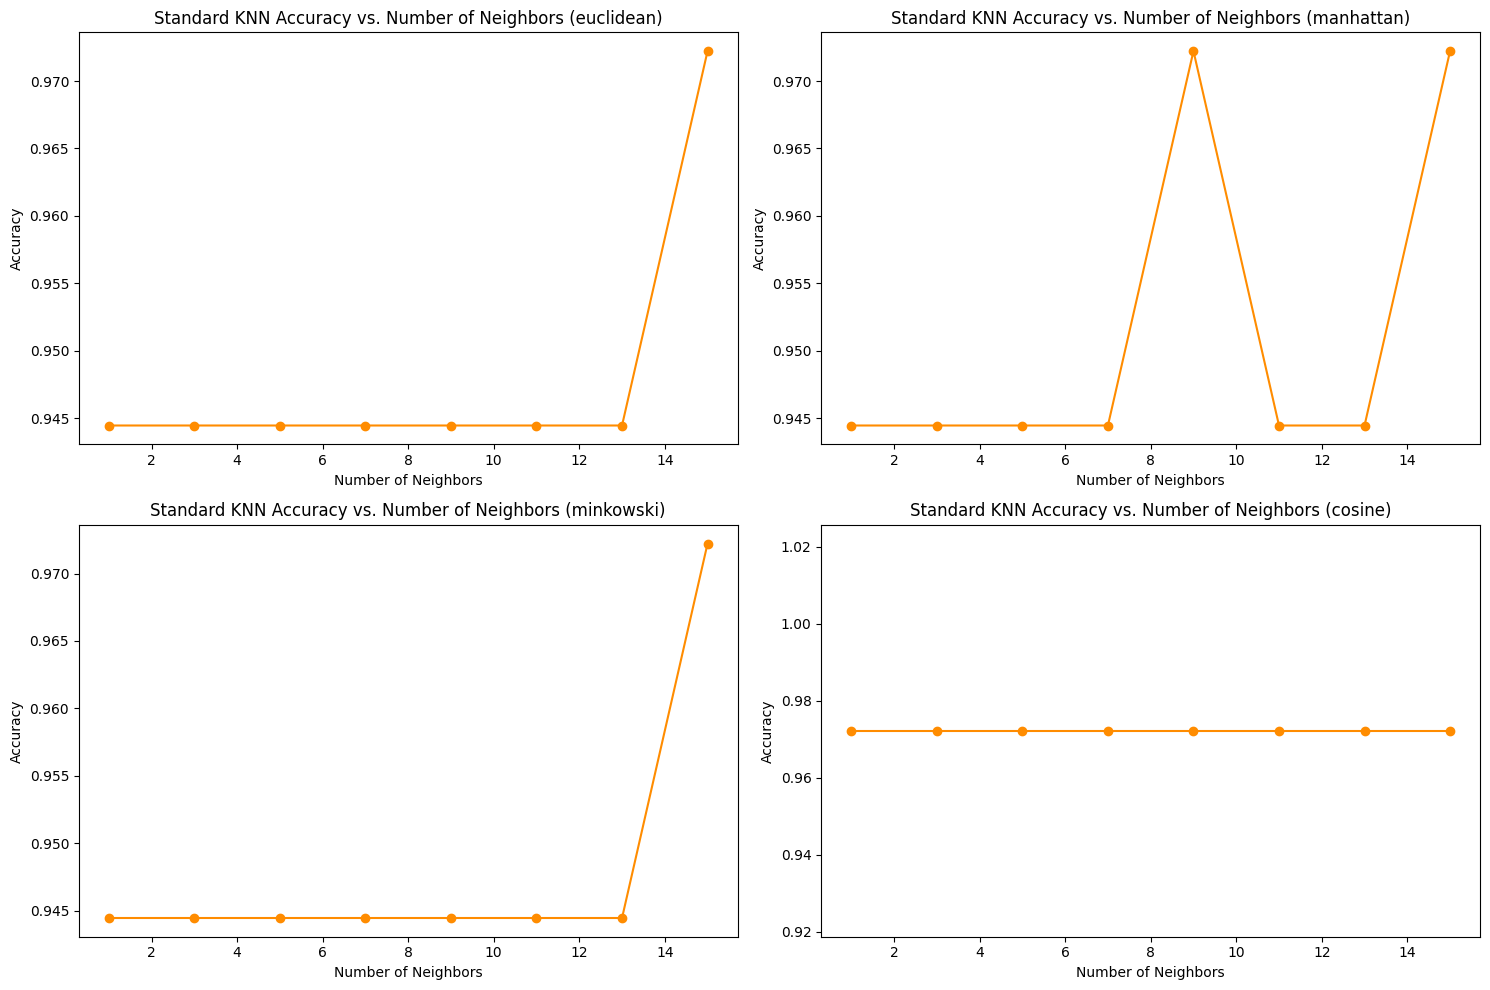

     k     metric  accuracy  precision    recall        f1
0    1  euclidean  0.944444   0.949383  0.944444  0.943604
1    3  euclidean  0.944444   0.949383  0.944444  0.943604
2    5  euclidean  0.944444   0.949383  0.944444  0.943604
3    7  euclidean  0.944444   0.949383  0.944444  0.943604
4    9  euclidean  0.944444   0.949383  0.944444  0.943604
5   11  euclidean  0.944444   0.949383  0.944444  0.943604
6   13  euclidean  0.944444   0.949383  0.944444  0.943604
7   15  euclidean  0.972222   0.974074  0.972222  0.972187
8    1  manhattan  0.944444   0.949383  0.944444  0.943604
9    3  manhattan  0.944444   0.949383  0.944444  0.943604
10   5  manhattan  0.944444   0.949383  0.944444  0.943604
11   7  manhattan  0.944444   0.949383  0.944444  0.943604
12   9  manhattan  0.972222   0.974074  0.972222  0.972187
13  11  manhattan  0.944444   0.951389  0.944444  0.944160
14  13  manhattan  0.944444   0.951389  0.944444  0.944160
15  15  manhattan  0.972222   0.974074  0.972222  0.9721

In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Load Wine dataset
wine = load_wine()
X = wine.data
y = wine.target

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define range of k values and metrics
k_values = range(1, 16, 2)
metrics = ['euclidean', 'manhattan', 'minkowski', 'cosine']

# List to store results
results_knn = []

# Iterate over each metric
for metric in metrics:
    for k in k_values:
        # Train KNN model
        knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
        knn.fit(X_train, y_train)

        # Evaluate model
        y_pred = knn.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        # Store the result as (k, metric, accuracy)
        results_knn.append((k, metric, accuracy, precision, recall, f1))

# Convert results to DataFrame for easy manipulation
results_knn_df = pd.DataFrame(results_knn, columns=['k', 'metric', 'accuracy', 'precision', 'recall', 'f1'])

# Plot error for each metric
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    metric_results = results_knn_df[results_knn_df['metric'] == metric]
    error = 1 - metric_results['accuracy']
    plt.subplot(2, 2, i + 1)
    plt.plot(metric_results['k'], error, 'bo-', color='darkorange')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Error')
    plt.title(f'Standard KNN Error vs. Number of Neighbors ({metric})')

plt.tight_layout()
plt.show()

# Plot accuracy for each metric
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    metric_results = results_knn_df[results_knn_df['metric'] == metric]
    plt.subplot(2, 2, i + 1)
    plt.plot(metric_results['k'], metric_results['accuracy'], 'bo-', color='darkorange')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.title(f'Standard KNN Accuracy vs. Number of Neighbors ({metric})')

plt.tight_layout()
plt.show()

print(results_knn_df)

# **Custom KNN for Breast Cancer Diagnosis Dataset**

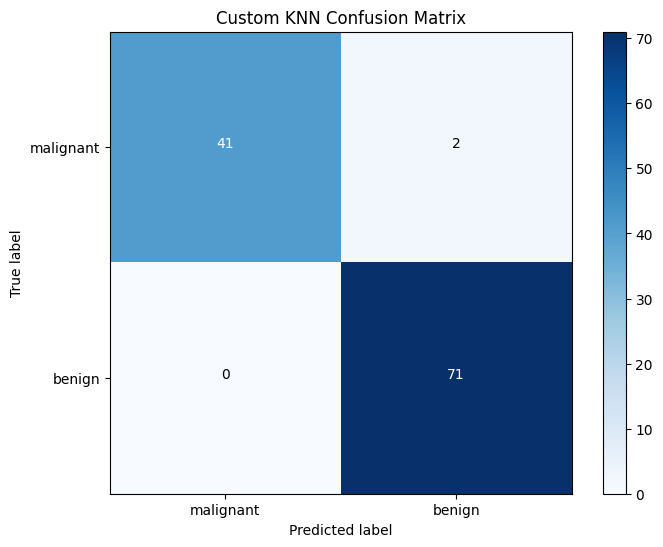

Custom KNN Metrics:
Accuracy: 0.9824561403508771
F1-score: 0.9823691172375383
Precision: 0.9829367940398942
Recall: 0.9824561403508771


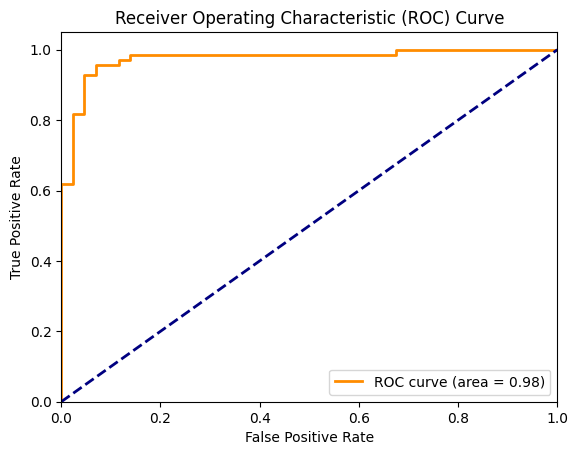

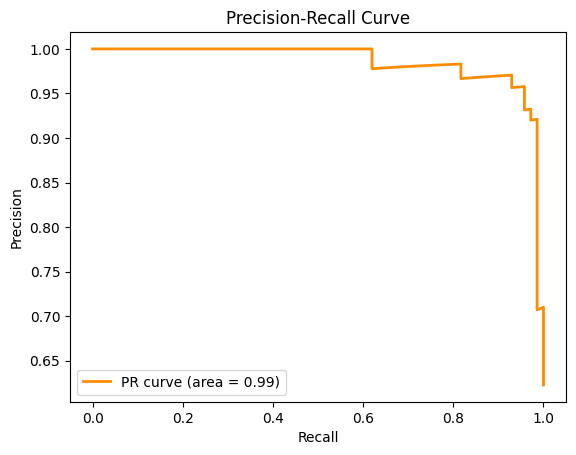

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt

# Load dataset
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CustomKNN class
class CustomKNN:
    def __init__(self, n_neighbors, metric):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            distances = []
            for j in range(len(self.X_train)):
                distance = self.metric(X[i], self.X_train[j])
                distances.append((distance, self.y_train[j]))
            distances.sort(key=lambda x: x[0])
            k_neighbors = [distances[i][1] for i in range(self.n_neighbors)]
            prediction = max(set(k_neighbors), key=k_neighbors.count)
            predictions.append(prediction)
        return predictions

# Define the custom distance metric
def custom_distance(x1, x2):
    x1_numeric = np.asarray(x1, dtype=np.float64)
    x2_numeric = np.asarray(x2, dtype=np.float64)
    x1_clean = x1_numeric[~np.isnan(x1_numeric)]
    x2_clean = x2_numeric[~np.isnan(x2_numeric)]
    sum_of_squares = np.sum((x1_clean - x2_clean) ** 2)
    sum_of_quadratics = np.sum((x1_clean - x2_clean) ** 4)
    if sum_of_quadratics == 0:
        return 0
    else:
        distance = 10 ** ((np.log(np.exp(1)) * (np.log(np.abs(sum_of_quadratics)) - np.log(np.abs(sum_of_squares)))) / (2 * np.log(10)))
        return distance

# Initialize and train CustomKNN
k = 11
custom_knn = CustomKNN(n_neighbors=k, metric=custom_distance)
custom_knn.fit(X_train, y_train)
y_pred_custom = custom_knn.predict(X_test)

# Plot Confusion Matrix for custom KNN
conf_matrix_custom = confusion_matrix(y_test, y_pred_custom)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_custom, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Custom KNN Confusion Matrix')
plt.colorbar()
plt.xticks(range(2), cancer.target_names)
plt.yticks(range(2), cancer.target_names)
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix_custom[i, j]), horizontalalignment='center', color='white' if conf_matrix_custom[i, j] > conf_matrix_custom.max()/2 else 'black')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Calculate metrics for custom KNN
accuracy_custom = accuracy_score(y_test, y_pred_custom)
f1_custom = f1_score(y_test, y_pred_custom, average='weighted')
precision_custom = precision_score(y_test, y_pred_custom, average='weighted')
recall_custom = recall_score(y_test, y_pred_custom, average='weighted')

# Print metrics for custom KNN
print("Custom KNN Metrics:")
print("Accuracy:", accuracy_custom)
print("F1-score:", f1_custom)
print("Precision:", precision_custom)
print("Recall:", recall_custom)

# Calculate decision scores for ROC and Precision-Recall curves
# Here, using probabilities is necessary, so we'll slightly adjust the predict method to return distances for this purpose
class CustomKNN:
    def __init__(self, n_neighbors, metric):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        decision_scores = []
        for i in range(len(X)):
            distances = []
            for j in range(len(self.X_train)):
                distance = self.metric(X[i], self.X_train[j])
                distances.append((distance, self.y_train[j]))
            distances.sort(key=lambda x: x[0])
            k_neighbors = [distances[i][1] for i in range(self.n_neighbors)]
            prediction = max(set(k_neighbors), key=k_neighbors.count)
            predictions.append(prediction)
            decision_scores.append(np.mean([dist[0] for dist in distances[:self.n_neighbors]])) # Use average distance as decision score
        return predictions, decision_scores

# Reinitialize and predict with decision scores
custom_knn = CustomKNN(n_neighbors=k, metric=custom_distance)
custom_knn.fit(X_train, y_train)
y_pred_custom, decision_scores_custom = custom_knn.predict(X_test)

decision_scores_custom = np.array(decision_scores_custom)
decision_scores_custom = 1 - decision_scores_custom
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, decision_scores_custom)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, decision_scores_custom)
pr_auc = auc(recall_vals, precision_vals)

plt.figure()
plt.plot(recall_vals, precision_vals, color='darkorange', lw=2, label='PR curve (area = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


# **Parameter Sensitivity**

<ipython-input-9-0e802276088f>:97: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([result[0] for result in results_custom_knn], [result[3] for result in results_custom_knn], 'bo-', color='darkorange')
<ipython-input-9-0e802276088f>:103: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([result[0] for result in results_custom_knn], error_custom_knn, 'bo-', color='darkorange')


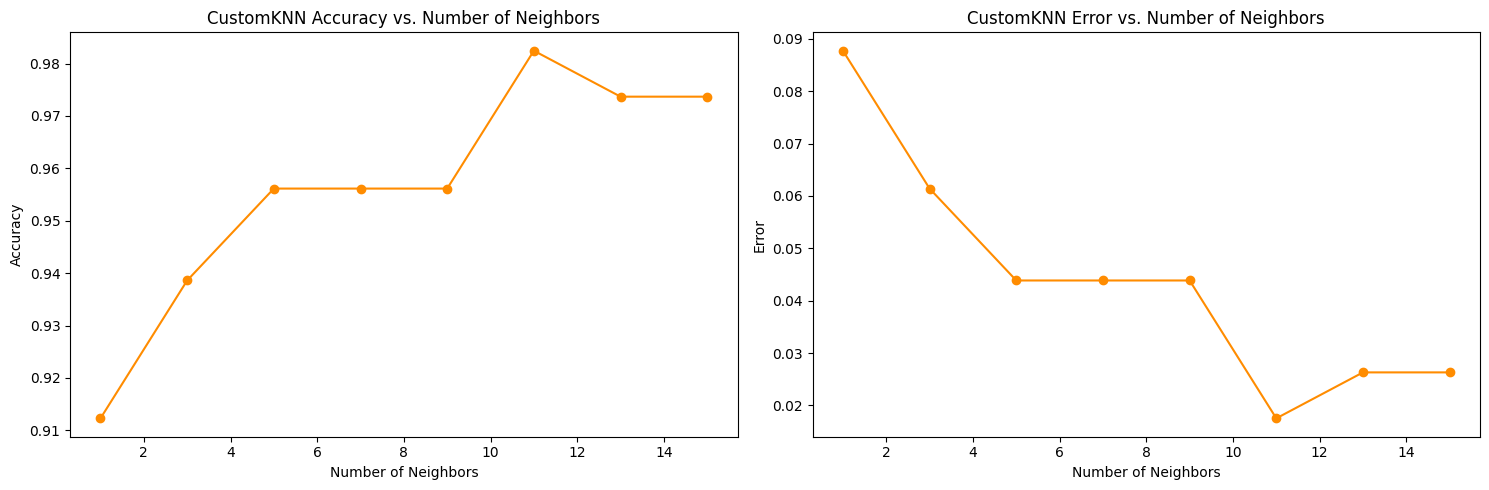

<ipython-input-9-0e802276088f>:116: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([result[0] for result in metric_results], [result[3] for result in metric_results], 'bo-', color='darkorange')


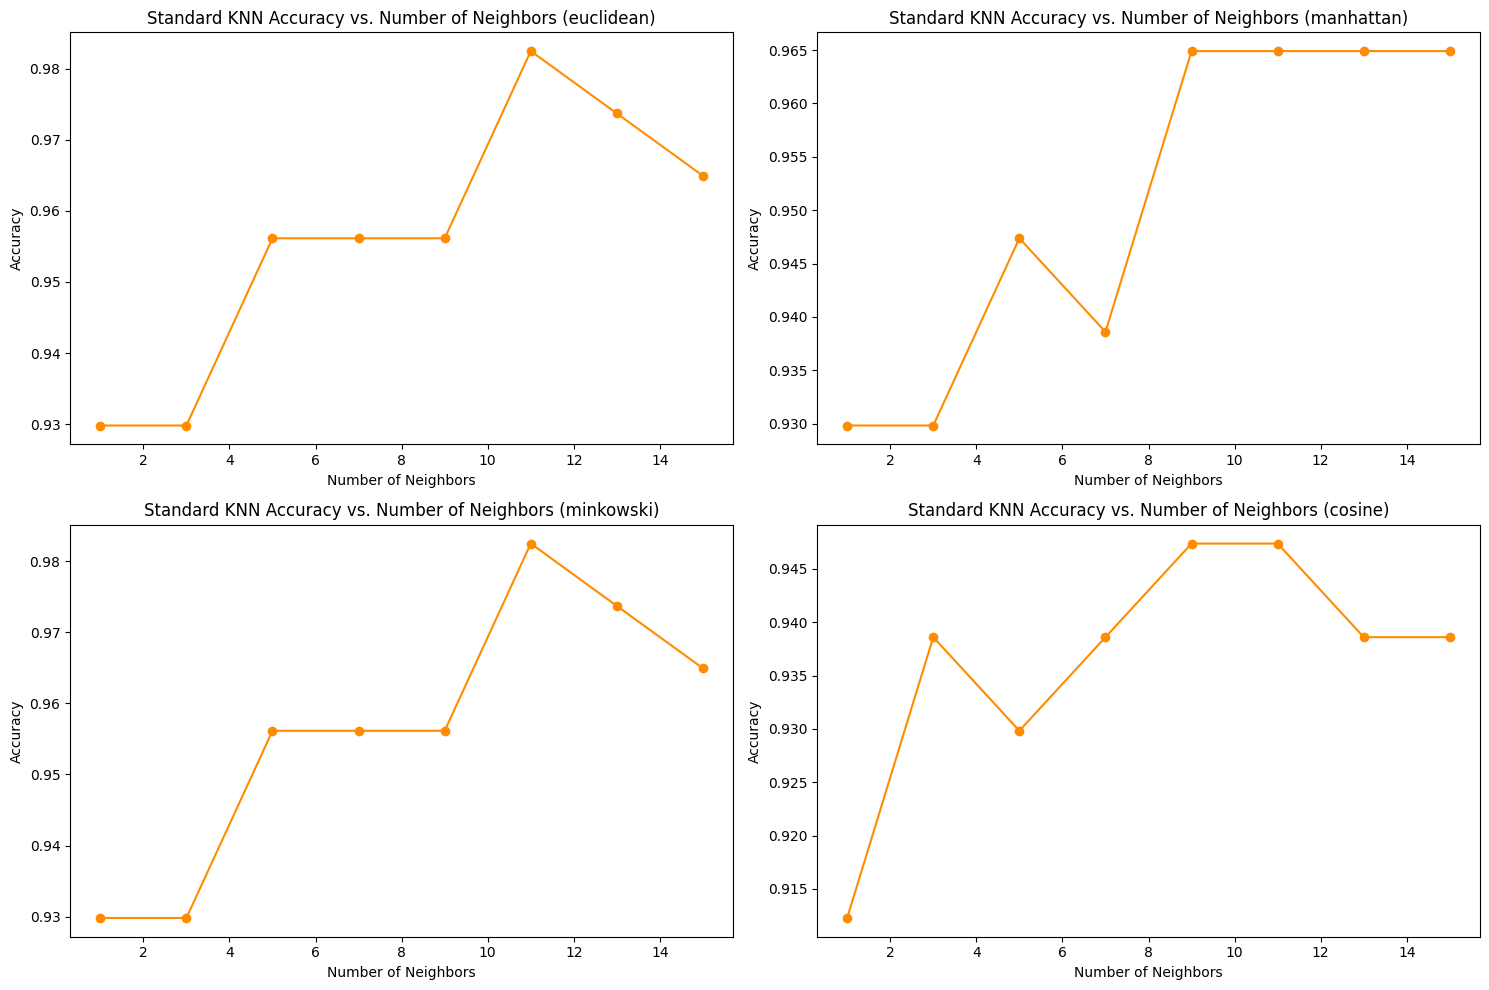

<ipython-input-9-0e802276088f>:135: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([result[0] for result in results_knn if result[1] == metric], error_knn[metric], 'bo-', color='darkorange')


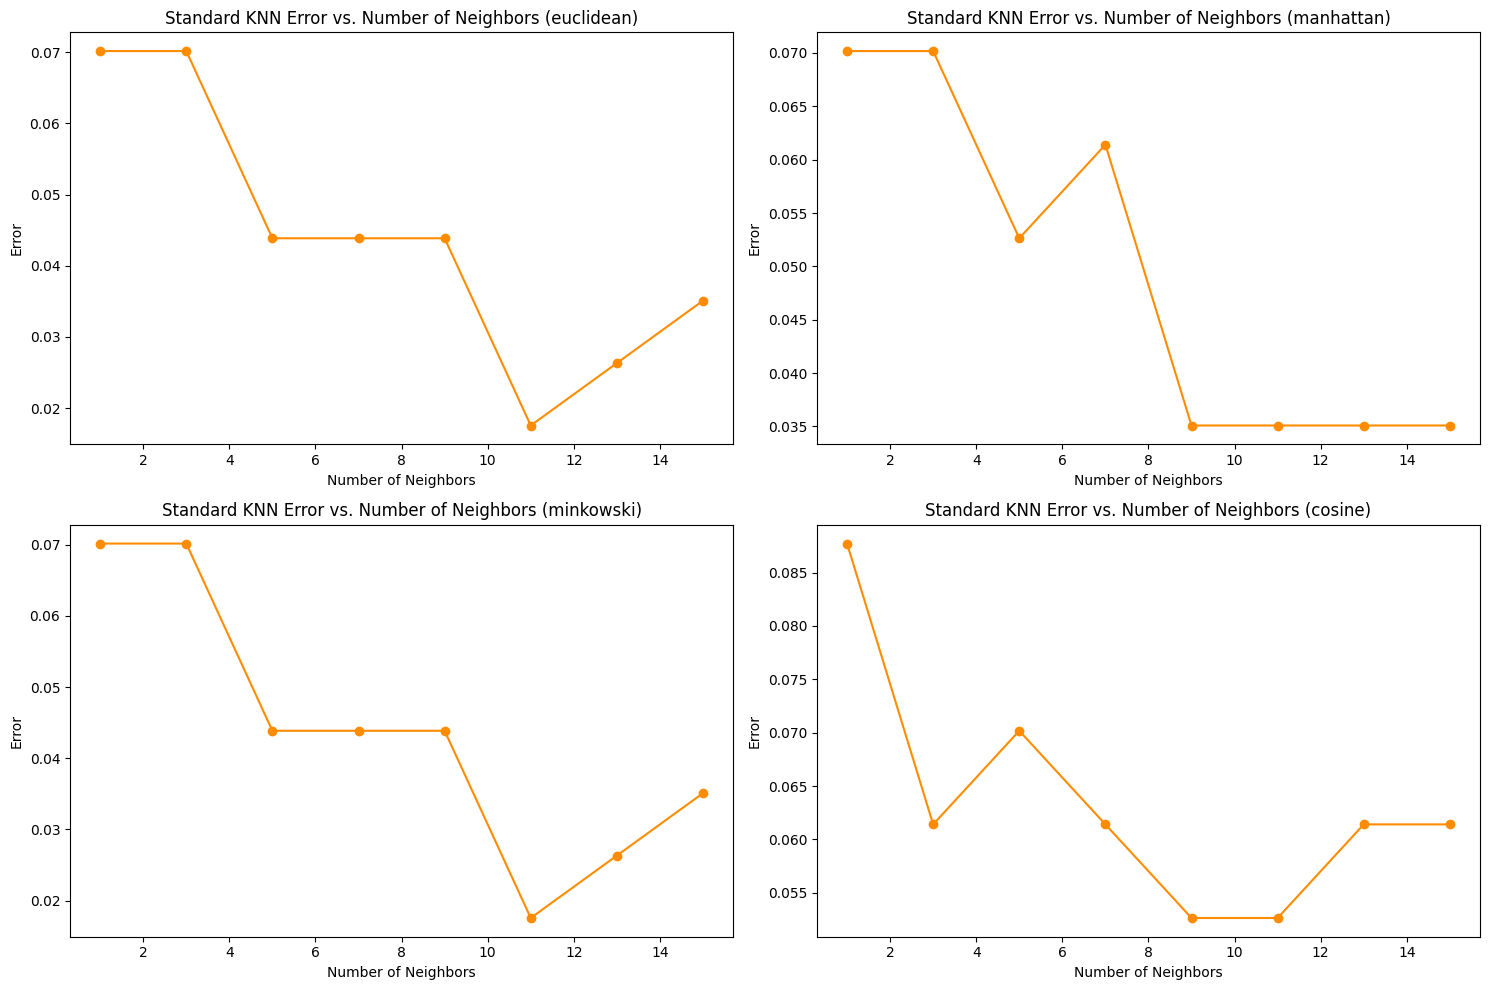

Custom KNN Results:
Neighbors: 1, Metric: custom_distance, Time: 1.5619s, Accuracy: 0.9123, Precision: 0.9178, Recall: 0.9437, F1 Score: 0.9306
Neighbors: 3, Metric: custom_distance, Time: 2.3780s, Accuracy: 0.9386, Precision: 0.9324, Recall: 0.9718, F1 Score: 0.9517
Neighbors: 5, Metric: custom_distance, Time: 2.1229s, Accuracy: 0.9561, Precision: 0.9459, Recall: 0.9859, F1 Score: 0.9655
Neighbors: 7, Metric: custom_distance, Time: 1.5335s, Accuracy: 0.9561, Precision: 0.9459, Recall: 0.9859, F1 Score: 0.9655
Neighbors: 9, Metric: custom_distance, Time: 1.5537s, Accuracy: 0.9561, Precision: 0.9459, Recall: 0.9859, F1 Score: 0.9655
Neighbors: 11, Metric: custom_distance, Time: 1.5552s, Accuracy: 0.9825, Precision: 0.9726, Recall: 1.0000, F1 Score: 0.9861
Neighbors: 13, Metric: custom_distance, Time: 1.5519s, Accuracy: 0.9737, Precision: 0.9722, Recall: 0.9859, F1 Score: 0.9790
Neighbors: 15, Metric: custom_distance, Time: 1.5625s, Accuracy: 0.9737, Precision: 0.9595, Recall: 1.0000, F1

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import matplotlib.pyplot as plt

# Load dataset
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the CustomKNN class
class CustomKNN:
    def __init__(self, n_neighbors, metric):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def predict(self, X):
        predictions = []
        for i in range(len(X)):
            distances = []
            for j in range(len(self.X_train)):
                distance = self.metric(X[i], self.X_train[j])
                distances.append((distance, self.y_train[j]))
            distances.sort(key=lambda x: x[0])
            k_neighbors = [distances[i][1] for i in range(self.n_neighbors)]
            prediction = max(set(k_neighbors), key=k_neighbors.count)
            predictions.append(prediction)
        return predictions

# Define the custom distance metric
def custom_distance(x1, x2):
    x1_numeric = np.asarray(x1, dtype=np.float64)
    x2_numeric = np.asarray(x2, dtype=np.float64)
    x1_clean = x1_numeric[~np.isnan(x1_numeric)]
    x2_clean = x2_numeric[~np.isnan(x2_numeric)]
    sum_of_squares = np.sum((x1_clean - x2_clean) ** 2)
    sum_of_quadratics = np.sum((x1_clean - x2_clean) ** 4)
    if sum_of_quadratics == 0:
        return 0
    else:
        distance = 10 ** ((np.log(np.exp(1)) * (np.log(np.abs(sum_of_quadratics)) - np.log(np.abs(sum_of_squares)))) / (2 * np.log(10)))
        return distance

# Perform parameter sensitivity analysis for CustomKNN
n_neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15]
metric_range = [custom_distance]

results_custom_knn = []
for n_neighbors in n_neighbors_range:
    for metric in metric_range:
        custom_knn = CustomKNN(n_neighbors, metric)
        start_time = time.time()
        custom_knn.fit(X_train, y_train)
        y_pred = custom_knn.predict(X_test)
        end_time = time.time()
        execution_time = end_time - start_time
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results_custom_knn.append((n_neighbors, metric.__name__, execution_time, accuracy, precision, recall, f1))

# Perform parameter sensitivity analysis for standard KNN
metric_range = ['euclidean', 'manhattan', 'minkowski', 'cosine']

results_knn = []
for n_neighbors in n_neighbors_range:
    for metric in metric_range:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        start_time = time.time()
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        end_time = time.time()
        execution_time = end_time - start_time
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        results_knn.append((n_neighbors, metric, execution_time, accuracy, precision, recall, f1))

# Calculate error for custom KNN
error_custom_knn = [1 - result[3] for result in results_custom_knn]

# Plot results
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot([result[0] for result in results_custom_knn], [result[3] for result in results_custom_knn], 'bo-', color='darkorange')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('CustomKNN Accuracy vs. Number of Neighbors')

plt.subplot(1, 2, 2)
plt.plot([result[0] for result in results_custom_knn], error_custom_knn, 'bo-', color='darkorange')
plt.xlabel('Number of Neighbors')
plt.ylabel('Error')
plt.title('CustomKNN Error vs. Number of Neighbors')

plt.tight_layout()
plt.show()

# Plot results for standard KNN
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metric_range):
    metric_results = [result for result in results_knn if result[1] == metric]
    plt.subplot(2, 2, i+1)
    plt.plot([result[0] for result in metric_results], [result[3] for result in metric_results], 'bo-', color='darkorange')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.title(f'Standard KNN Accuracy vs. Number of Neighbors ({metric})')

plt.tight_layout()
plt.show()

# Calculate error for standard KNN
error_knn = {}
for metric in metric_range:
    metric_results = [result for result in results_knn if result[1] == metric]
    error = [1 - result[3] for result in metric_results]
    error_knn[metric] = error

# Plot error for standard KNN
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metric_range):
    plt.subplot(2, 2, i+1)
    plt.plot([result[0] for result in results_knn if result[1] == metric], error_knn[metric], 'bo-', color='darkorange')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Error')
    plt.title(f'Standard KNN Error vs. Number of Neighbors ({metric})')

plt.tight_layout()
plt.show()

# Display results for custom KNN
print("Custom KNN Results:")
for result in results_custom_knn:
    print(f"Neighbors: {result[0]}, Metric: {result[1]}, Time: {result[2]:.4f}s, Accuracy: {result[3]:.4f}, Precision: {result[4]:.4f}, Recall: {result[5]:.4f}, F1 Score: {result[6]:.4f}")

# Display results for standard KNN
print("\nStandard KNN Results:")
for result in results_knn:
    print(f"Neighbors: {result[0]}, Metric: {result[1]}, Time: {result[2]:.4f}s, Accuracy: {result[3]:.4f}, Precision: {result[4]:.4f}, Recall: {result[5]:.4f}, F1 Score: {result[6]:.4f}")

# **Telco Customer Chrun Dataset**

Mounted at /content/drive


<ipython-input-10-b8dcd513341c>:155: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([result[0] for result in results_knn], [result[2] for result in results_knn], 'bo-', color='darkorange')
<ipython-input-10-b8dcd513341c>:162: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([result[0] for result in results_knn], error_knn, 'bo-', color='darkorange')


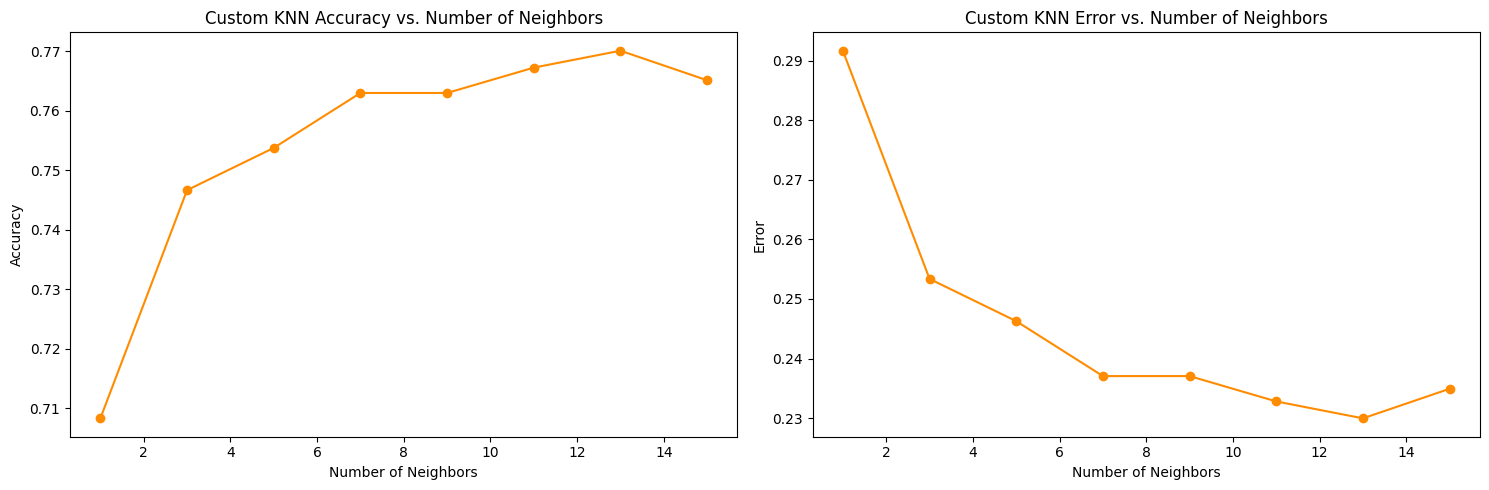

Best k: 13
t-statistic: 5.171182797814624
p-value: 2.4892101975644375e-07
Reject null hypothesis: The KNN model is significantly different from the actual labels.


    k      metric  accuracy     error  precision    recall        f1
0   1  Custom KNN  0.708304  0.291696   0.702109  0.708304  0.704985
1   3  Custom KNN  0.746629  0.253371   0.734341  0.746629  0.738970
2   5  Custom KNN  0.753726  0.246274   0.737910  0.753726  0.742744
3   7  Custom KNN  0.762952  0.237048   0.745833  0.762952  0.749741
4   9  Custom KNN  0.762952  0.237048   0.746093  0.762952  0.750062
5  11  Custom KNN  0.767211  0.232789   0.749120  0.767211  0.751950
6  13  Custom KNN  0.770050  0.229950   0.752657  0.770050  0.755306
7  15  Custom KNN  0.765082  0.234918   0.747898  0.765082  0.751506


In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, precision_recall_curve

# Mount Google Drive if running in Google Colab
from google.colab import drive
drive.mount('/content/drive')

# Define file paths for saving checkpoints
data_path = '/content/drive/My Drive/telco_data.pkl'
preprocessor_path = '/content/drive/My Drive/preprocessor.pkl'
train_test_data_path = '/content/drive/My Drive/train_test_data.pkl'
results_knn_path = '/content/drive/My Drive/results_knn.pkl'
distances_path = '/content/drive/My Drive/distances.pkl'

# Load the dataset
telco_data = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Preprocess the data
X = telco_data.drop(['customerID', 'Churn'], axis=1)
y = telco_data['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Save preprocessed data
with open(data_path, 'wb') as f:
    pickle.dump((X, y), f)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess numerical and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Fit and transform the preprocessor on training data, and transform the test data
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Save the preprocessor
with open(preprocessor_path, 'wb') as f:
    pickle.dump(preprocessor, f)

# Save train and test data
with open(train_test_data_path, 'wb') as f:
    pickle.dump((X_train, X_test, y_train, y_test), f)

# KNN implementation
class KNN:
    def __init__(self, k=5):
        self.k = k

    def fit(self, X, y):
        self.X_train = X.toarray()  # Convert to dense array
        self.y_train = y

    def predict(self, X_test, distances=None):
        X_test = X_test.toarray()  # Convert to dense array
        if distances is None:
            distances = self.compute_distances(X_test)
        y_pred = self.predict_labels(distances)
        return y_pred, distances

    def compute_distances(self, X_test):
        distances = []
        X_train_dense = self.X_train
        for x_test in X_test:
            x_test = x_test.reshape(1, -1)
            dist = self.custom_distance(X_train_dense, x_test)
            distances.append(dist)
        return np.array(distances)

    def custom_distance(self, X_train, x_test):
        distances = []
        for x1 in X_train:
            x1_numeric = np.asarray(x1, dtype=np.float64)
            x2_numeric = np.asarray(x_test, dtype=np.float64)
            x1_clean = x1_numeric[~np.isnan(x1_numeric)]
            x2_clean = x2_numeric[~np.isnan(x2_numeric)]
            sum_of_squares = np.sum((x1_clean - x2_clean) ** 2)
            sum_of_quadratics = np.sum((x1_clean - x2_clean) ** 4)
            if sum_of_quadratics == 0:
                distance = 0
            else:
                distance = 10 ** ((np.log(np.exp(1)) * (np.log(np.abs(sum_of_quadratics)) - np.log(np.abs(sum_of_squares)))) / (2 * np.log(10)))
            distances.append(distance)
        return distances

    def predict_labels(self, distances):
        y_pred = []
        for dist in distances:
            nearest_indices = np.argsort(dist)[:self.k]
            nearest_indices = np.clip(nearest_indices, 0, len(self.y_train) - 1)  # Clip indices to valid range
            nearest_labels = self.y_train.iloc[nearest_indices]
            unique, counts = np.unique(nearest_labels, return_counts=True)
            label = unique[np.argmax(counts)]
            y_pred.append(label)
        return np.array(y_pred)

# Initialize lists to store results
k_values = list(range(1, 16, 2))
results_knn = []

# Compute distances once and reuse them
knn = KNN()
knn.fit(X_train, y_train)
_, distances = knn.predict(X_test)

# Save distances
with open(distances_path, 'wb') as f:
    pickle.dump(distances, f)

# Train and evaluate the KNN classifier with different k values using precomputed distances
for k in k_values:
    knn.k = k
    y_pred, _ = knn.predict(X_test, distances=distances)

    accuracy = accuracy_score(y_test, y_pred)
    error = 1 - accuracy
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    results_knn.append((k, 'Custom KNN', accuracy, error, precision, recall, f1))

# Save results
with open(results_knn_path, 'wb') as f:
    pickle.dump(results_knn, f)

# Calculate error for standard KNN
error_knn = [result[3] for result in results_knn]

# Plot results for standard KNN
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot([result[0] for result in results_knn], [result[2] for result in results_knn], 'bo-', color='darkorange')
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.title('Custom KNN Accuracy vs. Number of Neighbors')


plt.subplot(1, 2, 2)
plt.plot([result[0] for result in results_knn], error_knn, 'bo-', color='darkorange')
plt.xlabel('Number of Neighbors')
plt.ylabel('Error')
plt.title('Custom KNN Error vs. Number of Neighbors')

plt.tight_layout()
plt.show()

# Perform statistical tests for the best k value of Euclidean distance
best_k = k_values[np.argmax([result[2] for result in results_knn])]

knn.k = best_k
y_pred, _ = knn.predict(X_test, distances=distances)

# Perform t-test
t_stat, p_val = stats.ttest_ind(y_test, y_pred)
print(f"Best k: {best_k}")
print("t-statistic:", t_stat)
print("p-value:", p_val)

if p_val < 0.05:
    print("Reject null hypothesis: The KNN model is significantly different from the actual labels.")
else:
    print("Fail to reject null hypothesis: The KNN model is not significantly different from the actual labels.")
print("\n")

results_knn = pd.DataFrame(results_knn, columns=['k', 'metric', 'accuracy', 'error', 'precision', 'recall', 'f1'])
print(results_knn)

# **Parameter Sensitivity**

<ipython-input-11-7f55c9353562>:98: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([result[0] for result in metric_results], [result[3] for result in metric_results], 'bo-', color='darkorange')


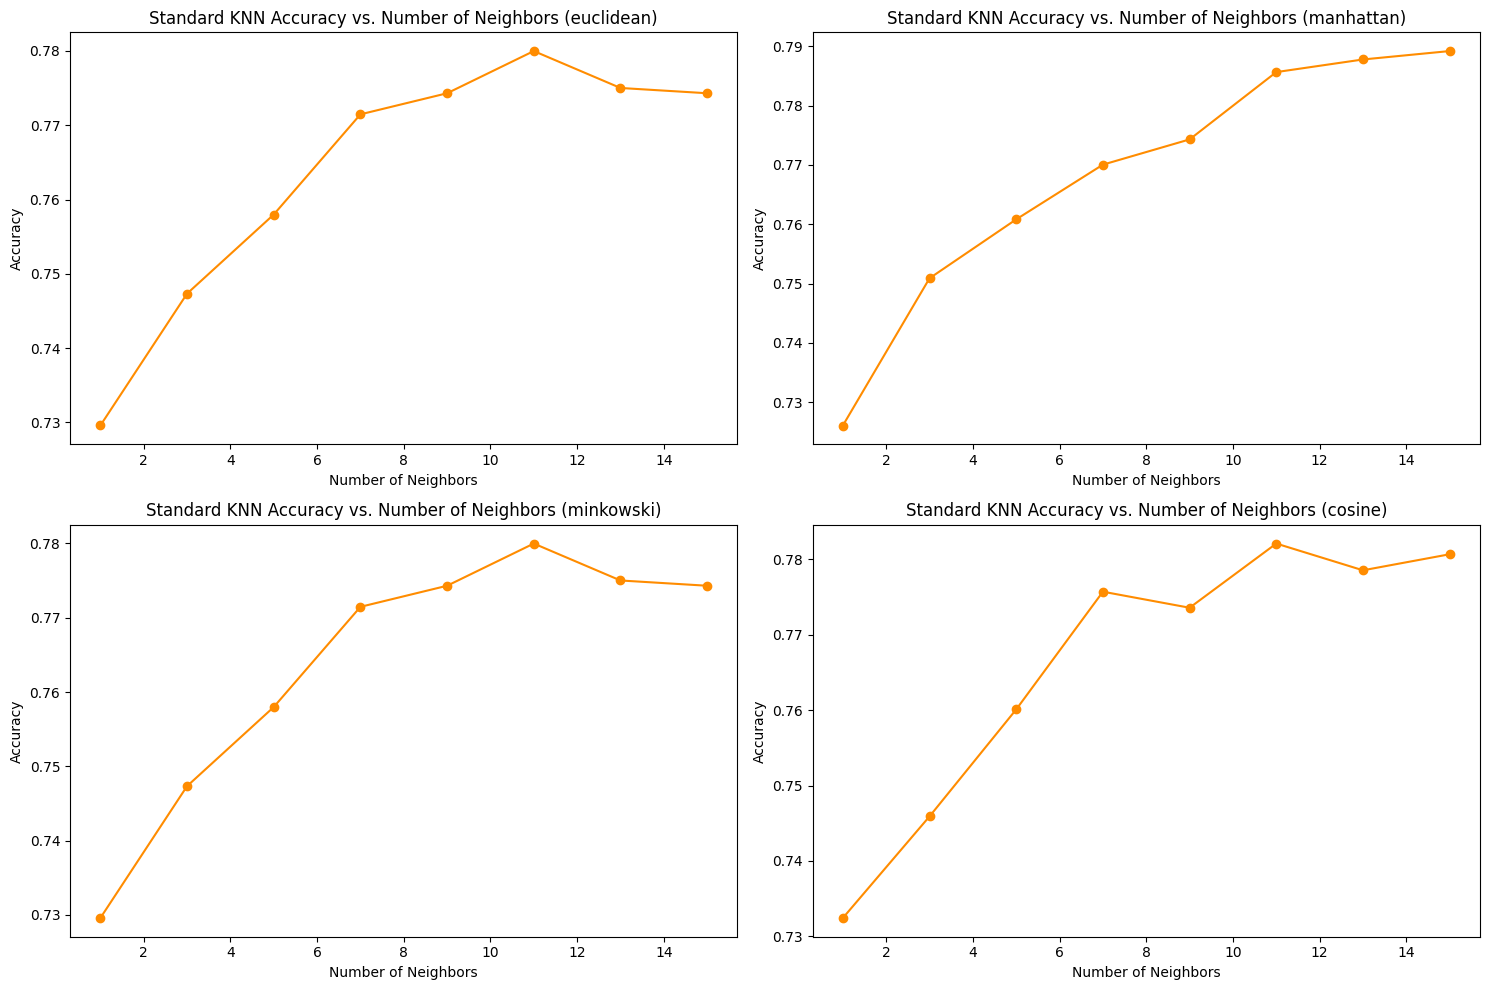

<ipython-input-11-7f55c9353562>:117: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot([result[0] for result in results_knn if result[1] == metric], error_knn[metric], 'bo-', color='darkorange')


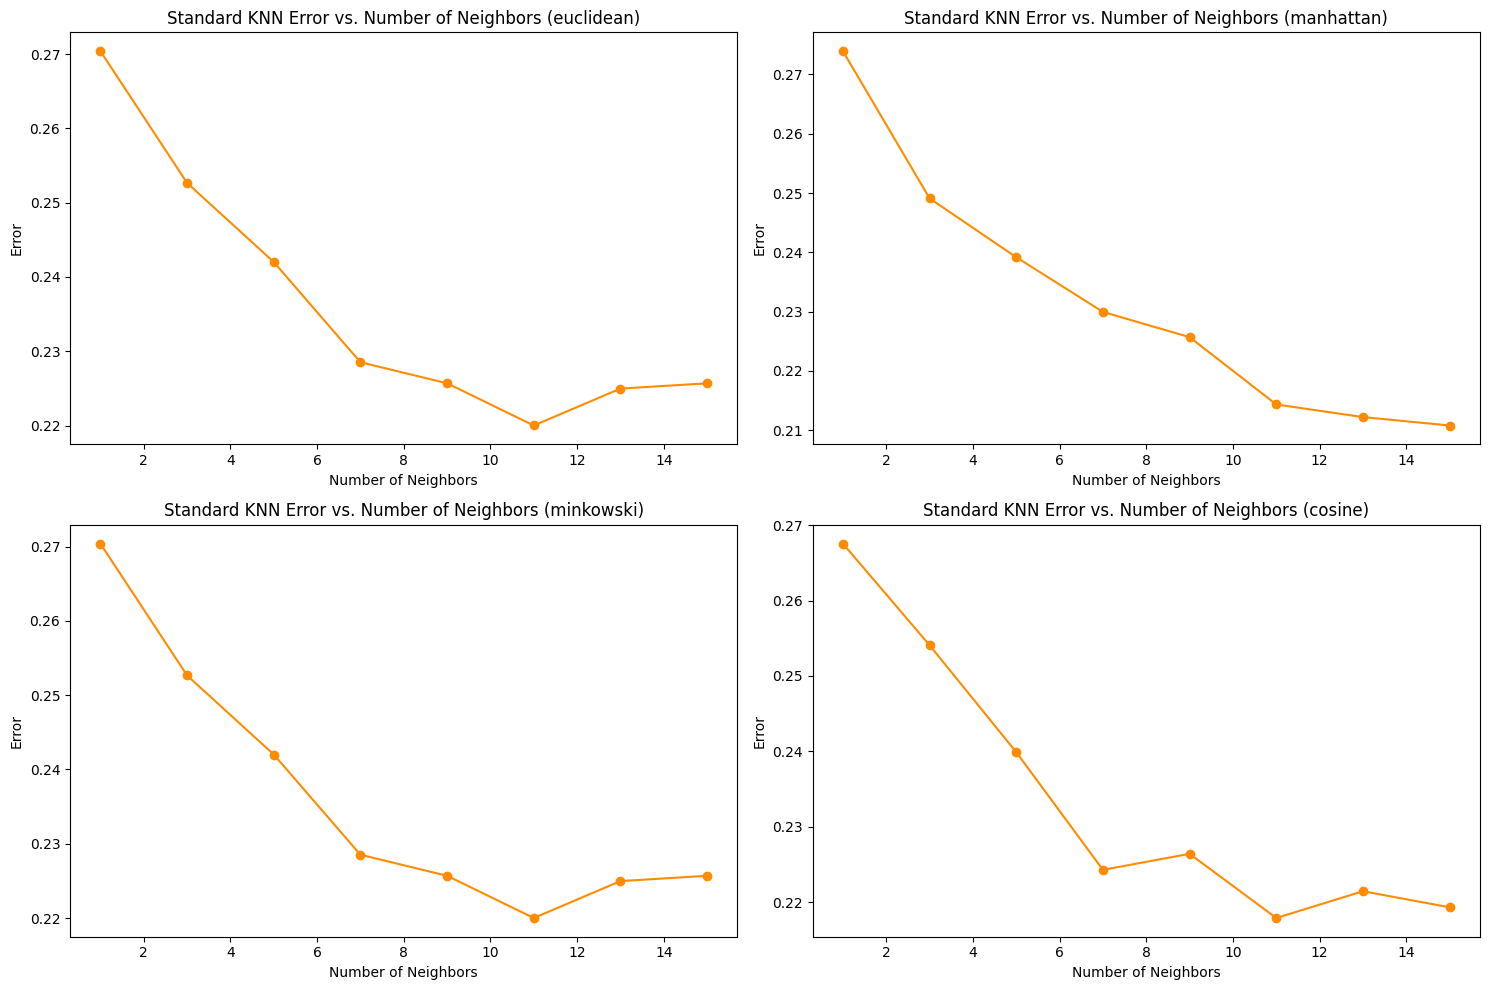


Standard KNN Results:
Neighbors: 1, Metric: euclidean, Time: 2.6023s, Accuracy: 0.7296, Precision: 0.7336, Recall: 0.7296, F1 Score: 0.7315
Neighbors: 1, Metric: manhattan, Time: 58.3968s, Accuracy: 0.7260, Precision: 0.7318, Recall: 0.7260, F1 Score: 0.7287
Neighbors: 1, Metric: minkowski, Time: 2.6939s, Accuracy: 0.7296, Precision: 0.7336, Recall: 0.7296, F1 Score: 0.7315
Neighbors: 1, Metric: cosine, Time: 2.7882s, Accuracy: 0.7324, Precision: 0.7350, Recall: 0.7324, F1 Score: 0.7337
Neighbors: 3, Metric: euclidean, Time: 2.5022s, Accuracy: 0.7473, Precision: 0.7427, Recall: 0.7473, F1 Score: 0.7448
Neighbors: 3, Metric: manhattan, Time: 58.8686s, Accuracy: 0.7509, Precision: 0.7502, Recall: 0.7509, F1 Score: 0.7506
Neighbors: 3, Metric: minkowski, Time: 2.4639s, Accuracy: 0.7473, Precision: 0.7427, Recall: 0.7473, F1 Score: 0.7448
Neighbors: 3, Metric: cosine, Time: 2.9235s, Accuracy: 0.7459, Precision: 0.7384, Recall: 0.7459, F1 Score: 0.7416
Neighbors: 5, Metric: euclidean, Time

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.sparse import csr_matrix
import time
import matplotlib.pyplot as plt

# Load Telco customer churn dataset
telco_data = pd.read_csv('/content/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Preprocess the data
# Convert categorical variables to numerical using LabelEncoder
le = LabelEncoder()
telco_data['gender'] = le.fit_transform(telco_data['gender'])
telco_data['Partner'] = le.fit_transform(telco_data['Partner'])
telco_data['Dependents'] = le.fit_transform(telco_data['Dependents'])
telco_data['PhoneService'] = le.fit_transform(telco_data['PhoneService'])
telco_data['MultipleLines'] = le.fit_transform(telco_data['MultipleLines'])
telco_data['InternetService'] = le.fit_transform(telco_data['InternetService'])
telco_data['OnlineSecurity'] = le.fit_transform(telco_data['OnlineSecurity'])
telco_data['OnlineBackup'] = le.fit_transform(telco_data['OnlineBackup'])
telco_data['DeviceProtection'] = le.fit_transform(telco_data['DeviceProtection'])
telco_data['TechSupport'] = le.fit_transform(telco_data['TechSupport'])
telco_data['StreamingTV'] = le.fit_transform(telco_data['StreamingTV'])
telco_data['StreamingMovies'] = le.fit_transform(telco_data['StreamingMovies'])
telco_data['Contract'] = le.fit_transform(telco_data['Contract'])
telco_data['PaperlessBilling'] = le.fit_transform(telco_data['PaperlessBilling'])
telco_data['PaymentMethod'] = le.fit_transform(telco_data['PaymentMethod'])
telco_data['Churn'] = le.fit_transform(telco_data['Churn'])

# Split the data into features and target variable
X = telco_data.drop(['customerID', 'Churn'], axis=1)
y = telco_data['Churn']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Convert sparse matrices to dense arrays
X_train = X_train.toarray() if isinstance(X_train, csr_matrix) else X_train
X_test = X_test.toarray() if isinstance(X_test, csr_matrix) else X_test


# Perform parameter sensitivity analysis for CustomKNN
n_neighbors_range = [1, 3, 5, 7, 9, 11, 13, 15]

# Perform parameter sensitivity analysis for standard KNN
metric_range = ['euclidean', 'manhattan', 'minkowski', 'cosine']

results_knn = []
for n_neighbors in n_neighbors_range:
    for metric in metric_range:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric)
        start_time = time.time()
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        end_time = time.time()
        execution_time = end_time - start_time
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        results_knn.append((n_neighbors, metric, execution_time, accuracy, precision, recall, f1))


# Plot results for standard KNN
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metric_range):
    metric_results = [result for result in results_knn if result[1] == metric]
    plt.subplot(2, 2, i+1)
    plt.plot([result[0] for result in metric_results], [result[3] for result in metric_results], 'bo-', color='darkorange')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Accuracy')
    plt.title(f'Standard KNN Accuracy vs. Number of Neighbors ({metric})')

plt.tight_layout()
plt.show()

# Calculate error for standard KNN
error_knn = {}
for metric in metric_range:
    metric_results = [result for result in results_knn if result[1] == metric]
    error = [1 - result[3] for result in metric_results]
    error_knn[metric] = error

# Plot error for standard KNN
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metric_range):
    plt.subplot(2, 2, i+1)
    plt.plot([result[0] for result in results_knn if result[1] == metric], error_knn[metric], 'bo-', color='darkorange')
    plt.xlabel('Number of Neighbors')
    plt.ylabel('Error')
    plt.title(f'Standard KNN Error vs. Number of Neighbors ({metric})')

plt.tight_layout()
plt.show()

# Display results for standard KNN
print("\nStandard KNN Results:")
for result in results_knn:
    print(f"Neighbors: {result[0]}, Metric: {result[1]}, Time: {result[2]:.4f}s, Accuracy: {result[3]:.4f}, Precision: {result[4]:.4f}, Recall: {result[5]:.4f}, F1 Score: {result[6]:.4f}")


# **Execution Time**

In [ ]:
import numpy as np
import time

# Define the distance metrics
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))

def minkowski_distance(x, y, p=3):
    return np.sum(np.abs(x - y) ** p) ** (1 / p)

def cosine_distance(x, y):
    return 1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def custom_distance(x1, x2):
    x1_numeric = np.asarray(x1, dtype=np.float64)
    x2_numeric = np.asarray(x2, dtype=np.float64)
    x1_clean = x1_numeric[~np.isnan(x1_numeric)]
    x2_clean = x2_numeric[~np.isnan(x2_numeric)]
    sum_of_squares = np.sum((x1_clean - x2_clean)**2)
    sum_of_quadratics = np.sum((x1_clean - x2_clean)**4)
    distance = 10**((np.log(np.exp(1)) * (np.log(np.abs(sum_of_quadratics)) - np.log(np.abs(sum_of_squares)))) / (2 * np.log(10)))
    return distance

# Define a function to measure execution time and memory usage
def measure_performance(distance_func, data_size, n_features=100):
    x = np.random.random((data_size, n_features))
    y = np.random.random((data_size, n_features))
    start_time = time.time()
    for i in range(data_size):
        distance_func(x[i], y[i])
    end_time = time.time()
    return end_time - start_time

# Measure performance for different dataset sizes
dataset_sizes = [100, 1000, 10000]
results = {}

for size in dataset_sizes:
    results[size] = {
        'Euclidean': measure_performance(euclidean_distance, size),
        'Manhattan': measure_performance(manhattan_distance, size),
        'Minkowski': measure_performance(minkowski_distance, size),
        'Cosine': measure_performance(cosine_distance, size),
        'Custom': measure_performance(custom_distance, size)
    }

results

{100: {'Euclidean': 0.001401662826538086,
  'Manhattan': 0.0010576248168945312,
  'Minkowski': 0.002094268798828125,
  'Cosine': 0.0014519691467285156,
  'Custom': 0.0048885345458984375},
 1000: {'Euclidean': 0.0073544979095458984,
  'Manhattan': 0.0060007572174072266,
  'Minkowski': 0.013990402221679688,
  'Cosine': 0.00762176513671875,
  'Custom': 0.03047013282775879},
 10000: {'Euclidean': 0.07439994812011719,
  'Manhattan': 0.062235116958618164,
  'Minkowski': 0.11767578125,
  'Cosine': 0.09131765365600586,
  'Custom': 0.3034038543701172}}

# **Resource Usage**

In [ ]:
import numpy as np
import tracemalloc

# Define the distance metrics
def euclidean_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

def manhattan_distance(x, y):
    return np.sum(np.abs(x - y))

def minkowski_distance(x, y, p=3):
    return np.sum(np.abs(x - y) ** p) ** (1 / p)

def cosine_distance(x, y):
    return 1 - np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def custom_distance(x1, x2):
    x1_numeric = np.asarray(x1, dtype=np.float64)
    x2_numeric = np.asarray(x2, dtype=np.float64)
    x1_clean = x1_numeric[~np.isnan(x1_numeric)]
    x2_clean = x2_numeric[~np.isnan(x2_numeric)]
    sum_of_squares = np.sum((x1_clean - x2_clean)**2)
    sum_of_quadratics = np.sum((x1_clean - x2_clean)**4)
    distance = 10**((np.log(np.exp(1)) * (np.log(np.abs(sum_of_quadratics)) - np.log(np.abs(sum_of_squares)))) / (2 * np.log(10)))
    return distance

# Measure memory usage
def measure_memory_usage(distance_func, data_size, n_features=100):
    x = np.random.random((data_size, n_features))
    y = np.random.random((data_size, n_features))
    tracemalloc.start()
    for i in range(data_size):
        distance_func(x[i], y[i])
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return peak / (1024 * 1024)  # Convert to MB

# Measure memory usage for 10,000 samples
data_size = 10000
results_memory = {
    'Euclidean': measure_memory_usage(euclidean_distance, data_size),
    'Manhattan': measure_memory_usage(manhattan_distance, data_size),
    'Minkowski': measure_memory_usage(minkowski_distance, data_size),
    'Cosine': measure_memory_usage(cosine_distance, data_size),
    'Custom': measure_memory_usage(custom_distance, data_size)
}

results_memory

{'Euclidean': 0.00836944580078125,
 'Manhattan': 0.0065975189208984375,
 'Minkowski': 0.06917190551757812,
 'Cosine': 0.006866455078125,
 'Custom': 0.0741109848022461}